# **VARIATIONAL AUTOENCODERS**

In [83]:
# Standard Packages
import os
import sys
import time
import pickle
import numpy as np
import itertools

# Deep Learning
import torch

# Plotting Packages
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import BoundaryNorm

## Other Packages
from scipy.stats import kurtosis
from sklearn.cluster import KMeans
#import pyemma
#import mdtraj as md
#import paramiko

# !virtualenv /content/drive/MyDrive/pyemma_env
# !source /content/drive/MyDrive/pyemma_env/bin/activate;
# !pip install mdshare
# !pip install nglview


In [84]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Variational AutoEncoders for Protein Conformational Space Exploration**!

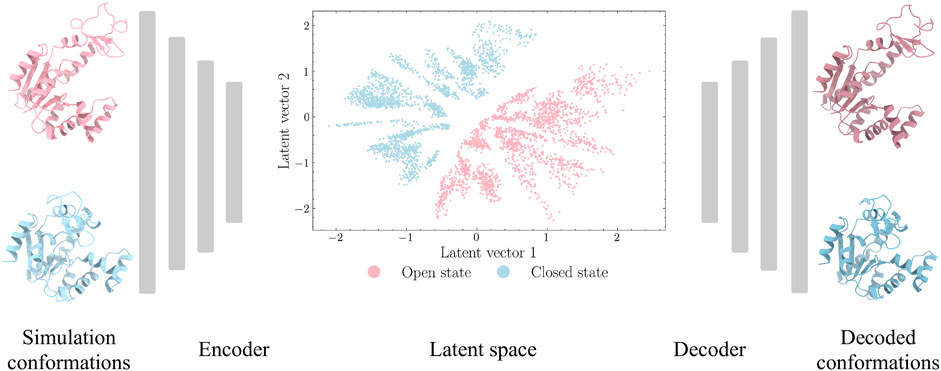

*Tian H, Jiang X, Trozzi F, Xiao S, Larson EC, Tao P. Explore Protein Conformational Space With Variational Autoencoder. Front Mol Biosci. 2021 Nov 12;8:781635. doi: 10.3389/fmolb.2021.781635. PMID: 34869602; PMCID: PMC8633506.*


https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f


In [85]:
class VariationalAutoEncoder(torch.nn.Module):
    def __init__(self, input_dim, nlayers, latent_dim, negative_slope=0.01):
        super().__init__()

        self.input_dim = input_dim
        self.nlayers = nlayers
        self.latent_dim = latent_dim
        self.negative_slope = negative_slope
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        delta = int((input_dim - latent_dim) / (nlayers + 1))

        # Encoder
        encoder = []
        nunits = input_dim
        for layer in range(nlayers):
            encoder.append(torch.nn.Linear(nunits, nunits - delta))
            encoder.append(torch.nn.LeakyReLU(negative_slope=self.negative_slope))
            nunits = nunits - delta
        self.encoder = torch.nn.Sequential(*encoder)

        # Latent Space (mean and log-variance)
        self.fc_mu = torch.nn.Linear(nunits, latent_dim)
        self.fc_log_var = torch.nn.Linear(nunits, latent_dim)

        # Decoder
        decoder = []
        nunits = latent_dim
        for layer in range(nlayers):
            decoder.append(torch.nn.Linear(nunits, nunits + delta))
            decoder.append(torch.nn.LeakyReLU(negative_slope=self.negative_slope))
            nunits = nunits + delta
        self.decoder = torch.nn.Sequential(*decoder)

        # Output
        self.output_layer = torch.nn.Sequential(
            torch.nn.Linear(nunits, input_dim),
            torch.nn.Sigmoid())

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        log_var = self.fc_log_var(encoded)
        latent = self.reparameterize(mu, log_var)
        decoded = self.decoder(latent)
        output = self.output_layer(decoded)
        return output, latent, mu, log_var

    # Training / Validation
    def train_model(self, train_dataloader, valid_dataloader, optimizer, epochs, save_model_path=None, checkpoint_interval=25):
        train_losses = []
        valid_losses = []

        print("Start Training:")
        for epoch in range(epochs):
            start_time = time.time()

            # Training step
            avg_train_loss = self.training_step(train_dataloader, optimizer)
            train_losses.append(avg_train_loss)

            # Validation step
            avg_valid_loss, _, _ = self.evaluate_model(valid_dataloader)
            valid_losses.append(avg_valid_loss)

            end_time = time.time()
            epoch_duration = end_time - start_time
            print(f'Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.3f}, Valid Loss: {avg_valid_loss:.3f}, Duration: {epoch_duration:.2f}s')

            # Checkpointing
            if save_model_path and (epoch % checkpoint_interval == 0 or epoch == epochs-1):
                checkpoint_path = os.path.join(save_model_path, f'checkpoint_epoch_{epoch+1}.pth')
                torch.save(self.state_dict(), checkpoint_path)

        return train_losses, valid_losses

    def training_step(self, dataloader, optimizer):
        self.train()
        epoch_train_losses = []
        for data in dataloader:
            data = data.to(self.device)
            optimizer.zero_grad()
            recon_batch, latent, mu, log_var = self(data)
            loss = self.loss_function(recon_batch, data, mu, log_var)
            loss.backward()
            optimizer.step()
            epoch_train_losses.append(loss.item())

        avg_loss = np.mean(epoch_train_losses)
        return avg_loss

    # Testing
    def evaluate_model(self, dataloader):
        self.eval()
        epoch_val_losses = []
        z = []; x_hat = []
        with torch.no_grad():
            for data in dataloader:
                data = data.to(self.device)
                output, latent, mu, log_var = self(data)
                loss = self.loss_function(output, data, mu, log_var)
                z.append(latent.cpu().numpy())
                x_hat.append(output.cpu().numpy())
                epoch_val_losses.append(loss.item())

        avg_loss = np.mean(epoch_val_losses)

        z = np.concatenate(z, axis=0)
        z = np.reshape(z, (-1, self.latent_dim))

        x_hat = np.concatenate(x_hat, axis=0)
        x_hat = np.reshape(x_hat, (-1, self.input_dim))
        return avg_loss, z, x_hat

    # Loss Function
    def loss_function(self, recon_x, x, mu, log_var):
        recon_loss = torch.nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
        kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return recon_loss + kl_divergence


def data_normalization(data_array):
    # Find the maximum and minimum values along axis 0 (column-wise)
    maximums = np.max(data_array, axis=0)
    minimums = np.min(data_array, axis=0)
    # Normalize the data_array
    norm_array = (data_array - minimums) / (maximums - minimums)
    return norm_array, maximums, minimums

def data_denormalization(normalized_data, max_values, min_values):
    # Denormalize the data
    denorm_data = normalized_data * (max_values - min_values) + min_values
    return denorm_data


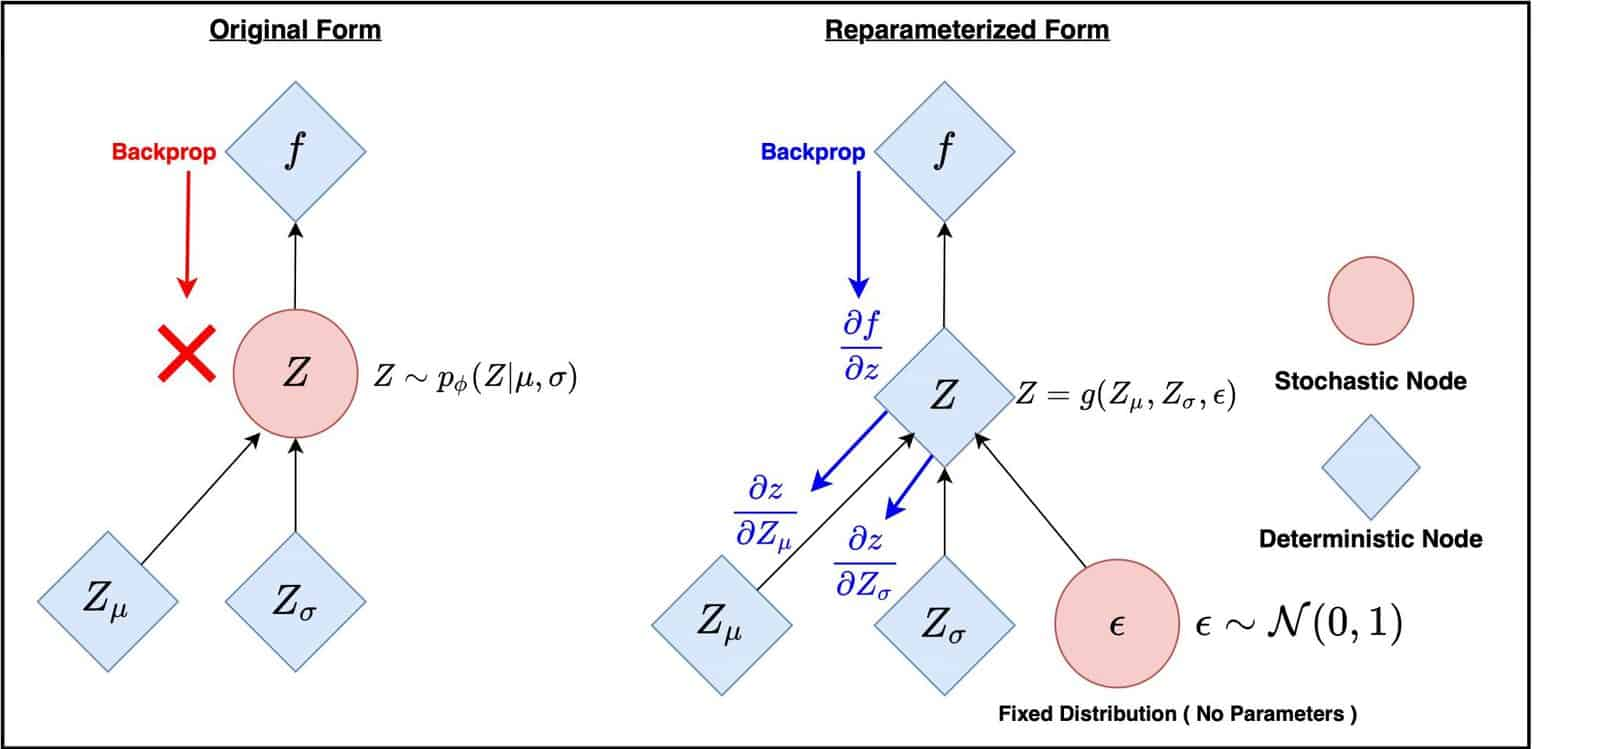

**Hyperparameters:**

* *partition* : Percentage selected of data as the training partition. Default = 0.8.

* *batch_size* :  Number of samples of the dataset per batch toload. It is the number of training examples utilized in one iteration. Default = 1.

* *latent_dim* : Number of dimensions of the latent space. It is a representation of compressed data in a low-dimensional space. Default = 2.

* *number_layers* : Number of layers in both encoder and decoder neural networks, excluding the layer of the latent space and the output layer. Default = 5.

* *learning_rate* : Learning rate used for the Adam optimizer. It is the parameter in an optimization algorithm that determines the step size at each iteration while moving toward a minimum of the loss function. Default = 0.0001

* *epochs* : Number of epochs required for training the model. It is the number times that the learning algorithm will work through the entire training dataset. Default = 100.

* *negative_slope* : Negative slope coefficient for LeakyReLU activation.

* *normalize* : Normalize the input data. Default = True.


In [86]:
# Hyperparameters

traj_file = "/content/drive/MyDrive/PhD/AE/Examples/WT_apo_md_b25_CA_ChainsA_DRY_imagedFit_2000frames.npy"
#test_traj_file = "../ML/Simulations/NPY/WT_holo_md_b25_CA_ChainsA_DRY_imagedFit.npy"

dt = 1
partition = 0.8
batch_size = 1
latent_dim = 2
nlayers = 5
lr = 0.0001
epochs = 100
negative_slope=0.2

normalize = True
save_model_path = os.getcwd()     # Path to save the model
print(save_model_path)

/content


**Data Setup/Featurization**

In [87]:
#load the input data

data = np.load(traj_file)[::dt]
#test_data = np.load(test_traj_file)

data = np.reshape(data, (len(data), data.shape[1]*data.shape[2]))
n_frames, n_features = np.shape(data)

if normalize:
    data, max_value, min_value = data_normalization(data)
    #test_data, max_test, min_test = data_normalization(test_data)

# Select the data for training and validation steps
select_train = int(partition*data.shape[0])
select_valid = int((1-partition)*data.shape[0])
train = data[:select_train, :]
valid = data[-select_valid:, :]
test  = data[:,:]

# Create torch tensors
train_data = torch.FloatTensor(train)
valid_data = torch.FloatTensor(valid)
test_data = torch.FloatTensor(test)

# Transform into a pytorch dataloaders
train_dataloader = torch.utils.data.DataLoader(dataset = train_data,
                                                batch_size = batch_size,
                                                drop_last=True,
                                                shuffle = True)
valid_dataloader = torch.utils.data.DataLoader(dataset = valid_data,
                                              batch_size = batch_size,
                                              drop_last=True,
                                              shuffle = False)
test_dataloader = torch.utils.data.DataLoader(dataset = test_data,
                                              batch_size = batch_size,
                                              drop_last=False,
                                              shuffle = False)

**Model Instantiation / Optimizer and Loss definition**

In [88]:
# Model Instatiation
model = VariationalAutoEncoder(input_dim = n_features, nlayers = nlayers-1, latent_dim = latent_dim, negative_slope=0.2)
# model.load_state_dict(torch.load("/content/drive/MyDrive/PhD/AE/model_parameters.pth", map_location=torch.device('cpu')))

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

# Loss function
BCE_loss = torch.nn.BCELoss()


**Train Model**

In [89]:
# Train Model

train_losses, valid_losses = VariationalAutoEncoder.train_model(
    model, train_dataloader, valid_dataloader, optimizer, epochs, save_model_path=save_model_path, checkpoint_interval=11)


Start Training:
Epoch 1/100 - Train Loss: 1050.731, Valid Loss: 1052.861, Duration: 97.41s
Epoch 2/100 - Train Loss: 1042.508, Valid Loss: 1051.773, Duration: 98.57s
Epoch 3/100 - Train Loss: 1037.035, Valid Loss: 1051.464, Duration: 96.47s
Epoch 4/100 - Train Loss: 1032.566, Valid Loss: 1051.027, Duration: 97.26s
Epoch 5/100 - Train Loss: 1029.085, Valid Loss: 1054.163, Duration: 93.22s
Epoch 6/100 - Train Loss: 1026.555, Valid Loss: 1053.176, Duration: 94.05s
Epoch 7/100 - Train Loss: 1025.378, Valid Loss: 1054.855, Duration: 93.29s
Epoch 8/100 - Train Loss: 1024.701, Valid Loss: 1056.178, Duration: 92.48s
Epoch 9/100 - Train Loss: 1024.770, Valid Loss: 1054.321, Duration: 92.70s
Epoch 10/100 - Train Loss: 1023.548, Valid Loss: 1053.323, Duration: 92.41s
Epoch 11/100 - Train Loss: 1023.426, Valid Loss: 1058.379, Duration: 95.40s
Epoch 12/100 - Train Loss: 1023.033, Valid Loss: 1051.391, Duration: 96.43s
Epoch 13/100 - Train Loss: 1022.847, Valid Loss: 1051.263, Duration: 94.01s
Epoch

**Test Model**

In [90]:
# Test Model
test_loss, test_z, test_xhat = model.evaluate_model(test_dataloader)
print(f'Test Loss: {test_loss:.3f}')
print(test_xhat)

Test Loss: 1022.081
[[0.48464093 0.14216164 0.6783295  ... 0.59151417 0.5226925  0.4003102 ]
 [0.47755948 0.19835155 0.5916136  ... 0.54506433 0.49899602 0.4041296 ]
 [0.47637758 0.18888363 0.6096822  ... 0.5496617  0.5031951  0.40403494]
 ...
 [0.6004657  0.45559037 0.5176408  ... 0.51063263 0.55698365 0.44722557]
 [0.5940904  0.46995667 0.52466923 ... 0.53458655 0.46120116 0.45075577]
 [0.52184373 0.5587687  0.5394146  ... 0.51305294 0.3225011  0.48280314]]


**Plot Loss vs Epochs**

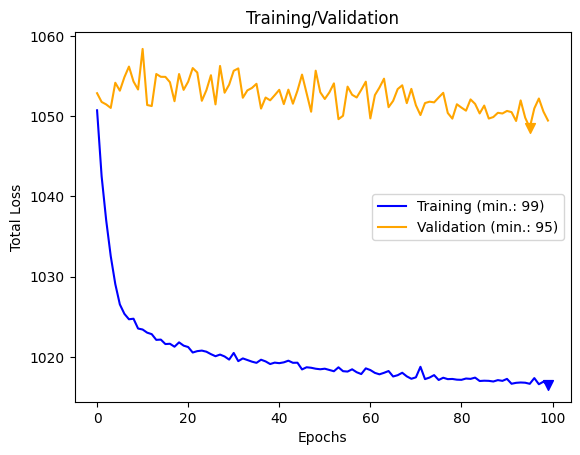

In [91]:
#Training/Validation Plot: Loss vs Epoch
train_loss = train_losses
val_loss = valid_losses
# Finding the minimum value points for train and validation losses
min_train_loss_value = min(train_loss)
min_val_loss_value = min(val_loss)
min_train_loss_idx = np.argmin(train_loss)
min_val_loss_idx = np.argmin(val_loss)

# Plot
plt.plot(range(len(train_loss)), train_loss, label=f"Training (min.: {min_train_loss_idx})", color='blue')
plt.plot(range(len(val_loss)), val_loss, label=f"Validation (min.: {min_val_loss_idx})", color='orange')

# Adding triangle markers at the minimum points
plt.scatter(min_train_loss_idx, train_loss[min_train_loss_idx], color='blue', marker='v', s=50)
plt.scatter(min_val_loss_idx, val_loss[min_val_loss_idx], color='orange', marker='v', s=50)

# Setting the rest of the plot elements
plt.legend()
plt.ylabel('Total Loss')
plt.xlabel('Epochs')
plt.title('Training/Validation')
plt.show()

**Trajectory Reconstruction**

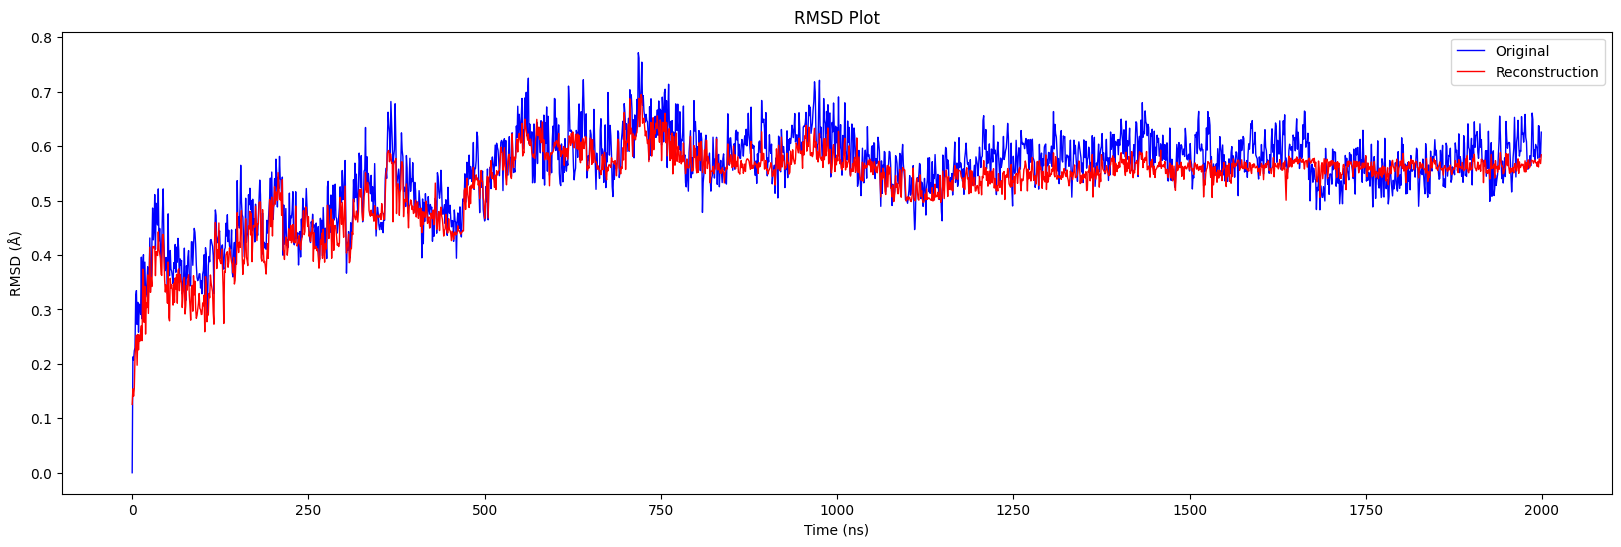

In [92]:
# RMSD

def calculate_rmsd(reference, trajectory):
    diff = reference - trajectory
    squared_diff = np.sum(diff ** 2, axis=2)
    mean_squared_diff = np.mean(squared_diff, axis=1)
    rmsd = np.sqrt(mean_squared_diff)
    return rmsd

def RMSD_plot(trajectory_data, output_data, moving_av="off"):
    # Create the reference trajectory
    reference = trajectory_data[0]

    # Compute RMSD for both datasets
    rmsd_trajectory = calculate_rmsd(reference, trajectory_data)
    rmsd_output = calculate_rmsd(reference, output_data)

    # Generate time array (assuming 0.5 ns per frame)
    time = np.arange(len(rmsd_trajectory))

    # Create the plot
    fig, ax = plt.subplots(figsize=(20, 6))

    # Plot RMSD over time for trajectory_data
    ax.plot(time, rmsd_trajectory, color='blue', linewidth=1, label='Original')

    # Plot RMSD over time for output_data
    ax.plot(time, rmsd_output, color='red', linewidth=1, label='Reconstruction')

    # Plot the moving average (optional)
    if moving_av == "on":
        window_size = 20  # Adjust window size as needed
        moving_avg_traj = np.convolve(rmsd_trajectory, np.ones(window_size)/window_size, mode='valid')
        moving_avg_out = np.convolve(rmsd_output, np.ones(window_size)/window_size, mode='valid')
        moving_avg_time = time[:len(moving_avg_traj)]
        ax.plot(moving_avg_time, moving_avg_traj, 'r', linewidth=0.5, label='Moving Average Trajectory')
        ax.plot(moving_avg_time, moving_avg_out, 'orange', linewidth=0.5, label='Moving Average Output')

    # Labels, title, and legend
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('RMSD (Å)')
    plt.title('RMSD Plot')
    plt.legend()

    # Show the plot
    plt.show()

data = np.reshape(data, (len(data), -1, 3))
output = np.reshape(test_xhat, (len(test_xhat), -1, 3))
RMSD_plot(data, output, moving_av="off")


#### **Latent Space Representation**

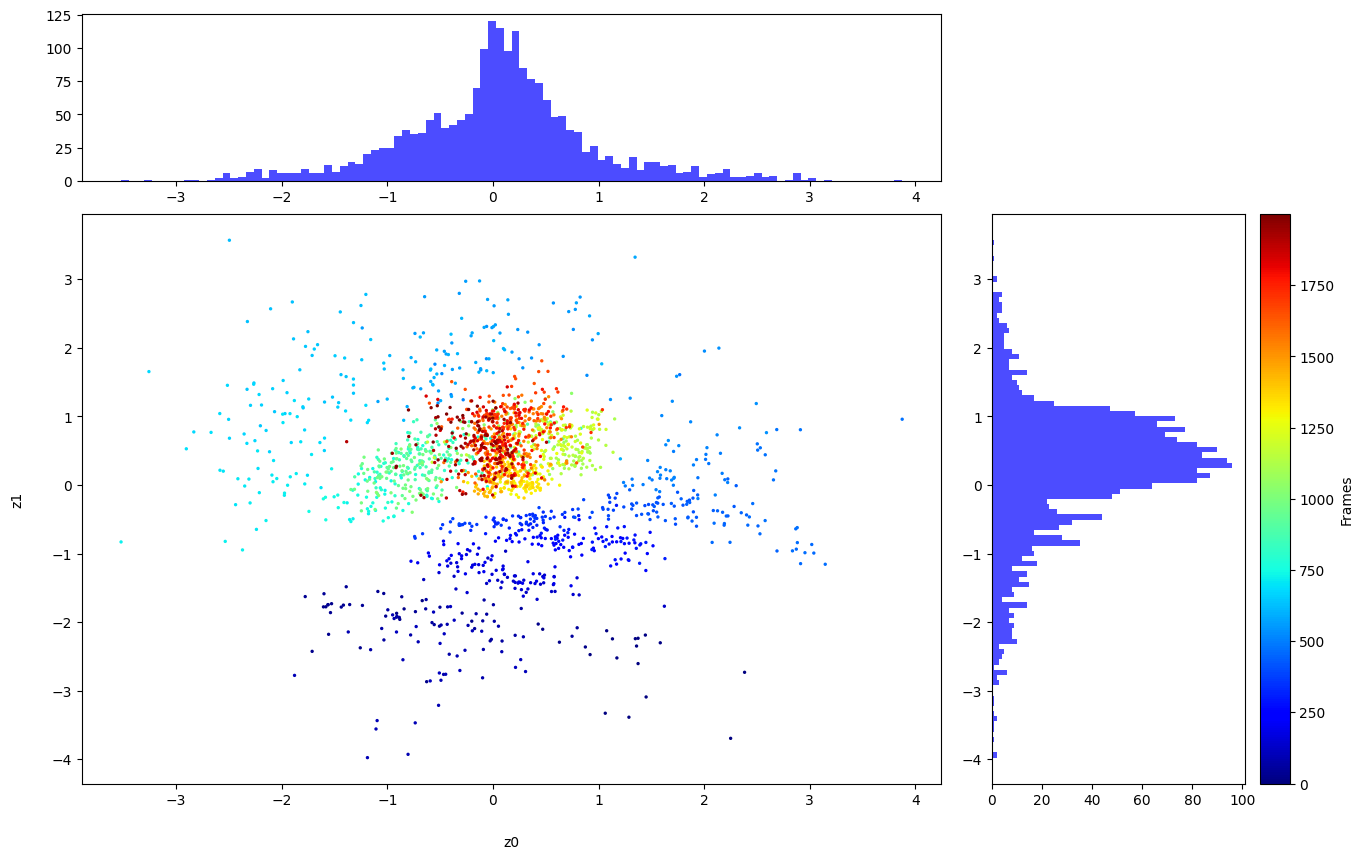

In [93]:
# Latent Space Representation

def plot_latent_space(z):
    gs = gridspec.GridSpec(4, 4)
    fig = plt.figure(figsize=(15, 10))

    ax_main = plt.subplot(gs[1:4, :3])
    ax_xDist = plt.subplot(gs[0, :3], sharex=ax_main)
    ax_yDist = plt.subplot(gs[1:4, 3], sharey=ax_main)

    sc = ax_main.scatter(z[::1, 0], z[::1, 1], c=np.arange(len(z)), alpha=1, cmap='jet', s=2)

    # Position and size of colorbar based on ax_yDist
    pos = ax_yDist.get_position()
    cbar_ax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.02, pos.height])
    cbar = plt.colorbar(sc, cax=cbar_ax)
    cbar.set_label('Frames')

    # X-axis marginal distribution
    ax_xDist.hist(z[::1, 0], bins=100, color='blue', alpha=0.7)

    # Y-axis marginal distribution
    ax_yDist.hist(z[::1, 1], bins=100, color='blue', alpha=0.7, orientation='horizontal')

    ax_main.set_xlabel('z0', labelpad=20)
    ax_main.set_ylabel('z1', labelpad=20)

    plt.show()

plot_latent_space(test_z)


#### **WT vs Mutant: Residue Anomaly Detection**

**RMSF**

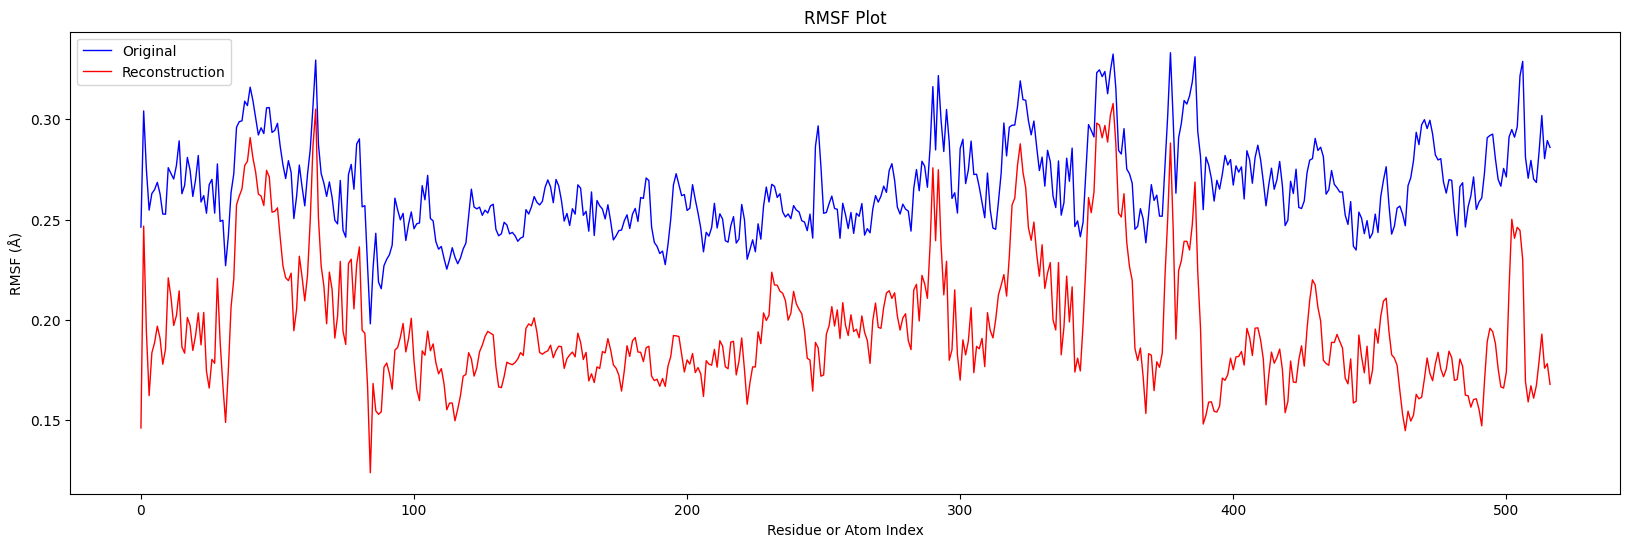

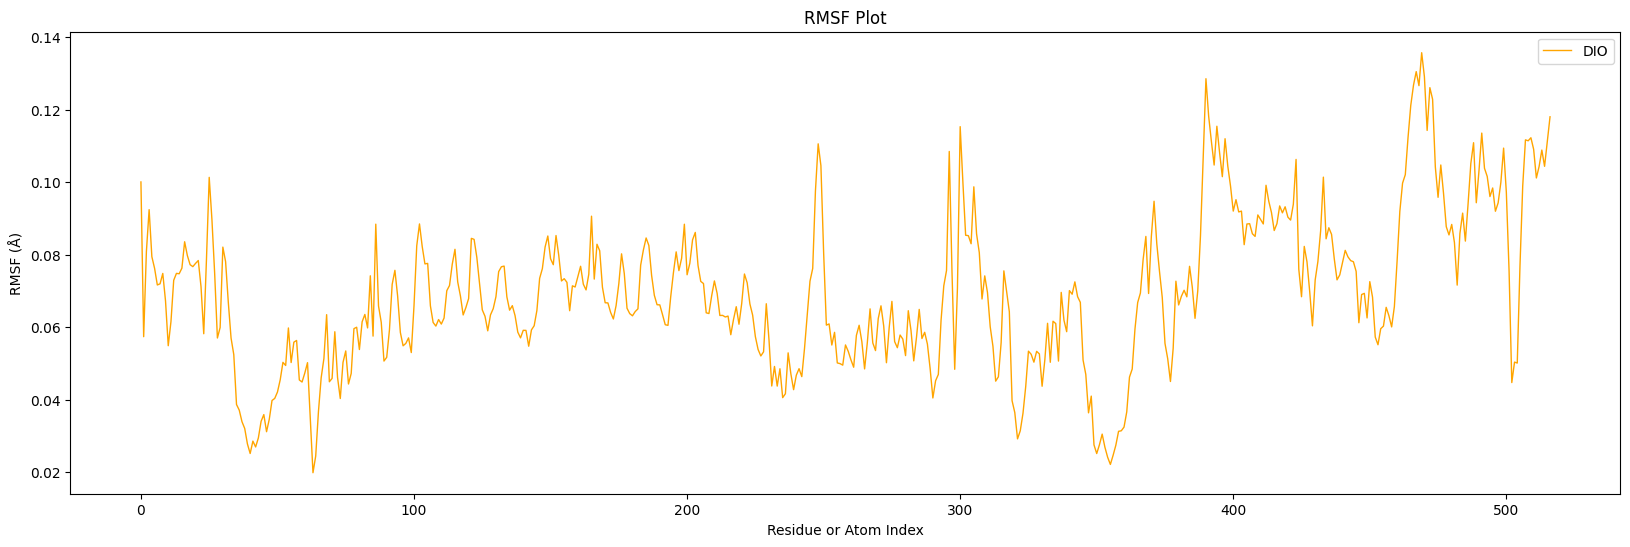

In [94]:
def calculate_rmsf(trajectory):
    # Calculate the mean position for each atom across all frames
    mean_positions = np.mean(trajectory, axis=0)

    # Calculate the squared deviations from the mean
    squared_deviations = (trajectory - mean_positions) ** 2

    # Sum the squared deviations for each coordinate, then average over frames and take the square root
    rmsf = np.sqrt(np.mean(np.sum(squared_deviations, axis=2), axis=0))
    return rmsf

def RMSF_plot(trajectory_data, output_data):
    # Calculate RMSF for both datasets
    rmsf_trajectory = calculate_rmsf(trajectory_data)
    rmsf_output = calculate_rmsf(output_data)

    # Create the plot
    fig, ax = plt.subplots(figsize=(20, 6))

    # Assuming the x-axis represents residue or atom indices
    indices = np.arange(len(rmsf_trajectory))

    # Plot RMSF for trajectory_data
    ax.plot(indices, rmsf_trajectory, color='blue', linewidth=1, label='Original')

    # Plot RMSF for output_data
    ax.plot(indices, rmsf_output, color='red', linewidth=1, label='Reconstruction')

    # Labels, title, and legend
    ax.set_xlabel('Residue or Atom Index')
    ax.set_ylabel('RMSF (Å)')
    plt.title('RMSF Plot')
    plt.legend()
    plt.show()

    # Create the plot
    fig, ax = plt.subplots(figsize=(20, 6))

    # Plot RMSF for DIO
    ax.plot(indices, (rmsf_trajectory - rmsf_output), color='orange', linewidth=1, label='DIO')

    # Labels, title, and legend
    ax.set_xlabel('Residue or Atom Index')
    ax.set_ylabel('RMSF (Å)')
    plt.title('RMSF Plot')
    plt.legend()
    plt.show()

WT_traj = data
Mut_traj = output
RMSF_plot(WT_traj, Mut_traj)

#### **PERFORMANCE ASSESSMENT CRITERIA**

Several previous studies focused on the evaluation of autoencoders on the generation of nonlinear featurization and the learned nonlinear representations of protein tertiary structures. In the current study, a similar strategy was employed to quantify and compare the performance of autoencoders and variational autoencoders. Specifically, four metrics were chosen as:

1. Spearman correlation coefficient
2. Pearson correlation coefficient (PCC)
3. root-mean-square deviation (RMSD)
4. discrete optimized protein energy (DOPE)

To evaluate the quality of deep learning models, two distance-based metrics, maximum mean discrepancy and earth mover’s distance, were applied to compare the training and generated distributions.

1. Maximum mean discrepancy (MMD). MMD is a statistical analysis to represent distances between projected distributions using mean embeddings of features.

2. Earth mover’s distance (EMD). EMD is a measurement to evaluate dissimilarity between two multi-dimensional probability distributions. It is also known as the Wasserstein metric in mathemathics. Analogically, two distributions on a two-dimensional surface could be considered as two piles of a certain amount of earth (dirt).


# **MARKOV STATE MODEL**

Analyze protein conformations using MSM with PyEMMA.

Parameters:

    z :  2D array of the latent space z.

    clusters :  1D array of cluster labels.

    lag_time :  Lag time for MSM estimation.

    lags_its :  Number of lags for implied timescale analysis (List).

    nits_its :  Number of ITS to compute.

    num_states_ck :  Number of states for the Chapman-Kolmogorov test.

    num_states_hmsm :  Number of states for coarse graining in HMSM.

    start_states :  List of starting states for TPT.

    end_states :  List of ending states for TPT.

In [95]:
# MSM Parameters:

n_clusters=5
lag_time=100
lags_its=50
nits_its=10
num_states_ck=n_clusters
num_states_hmsm=n_clusters
start_states=None
end_states=None

In [96]:
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters = kmeans.fit_predict(test_z)
print(clusters)

[3 3 3 ... 1 1 0]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


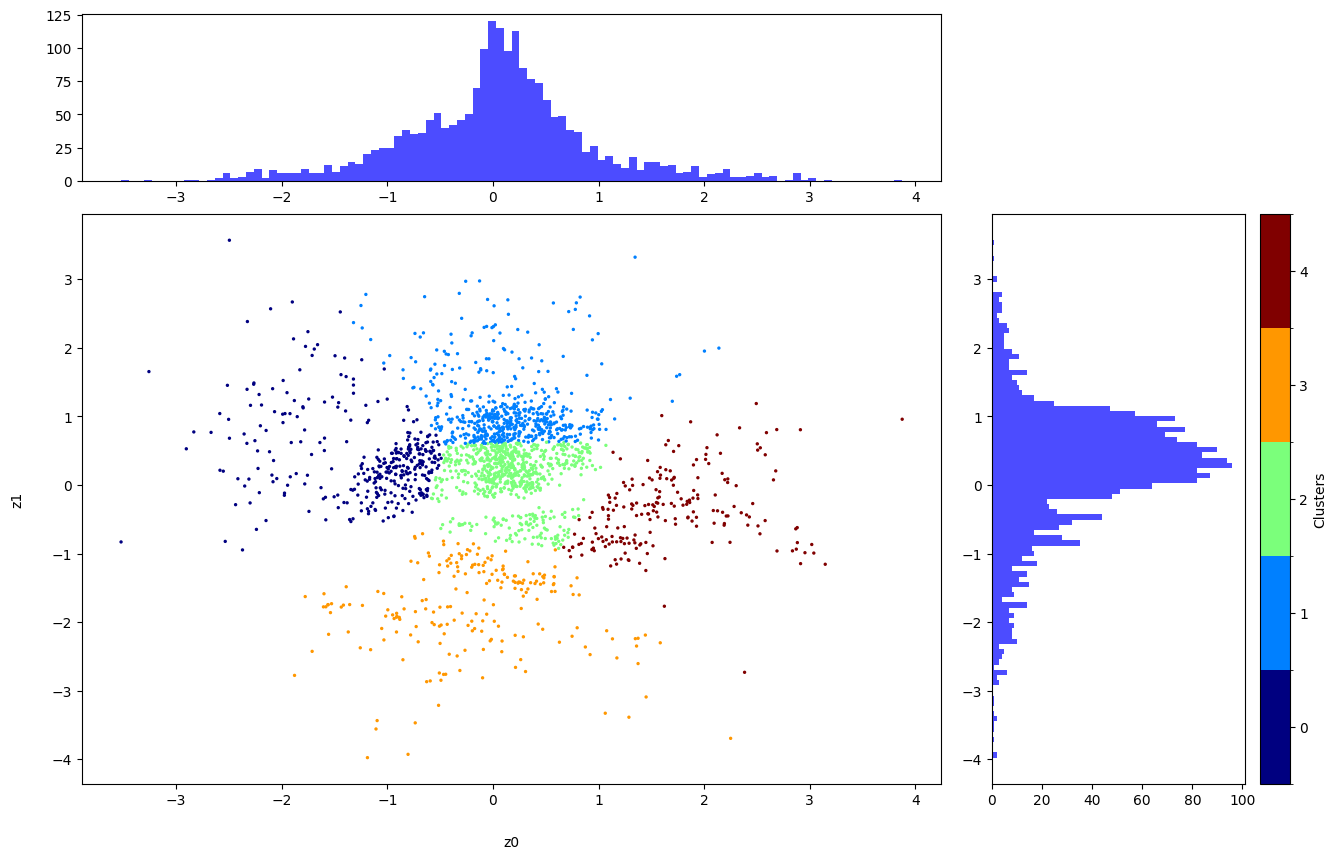

In [97]:
def plot_latent_space(z, clusters):

    y_unq = np.unique(clusters)
    gs = gridspec.GridSpec(4, 4)
    fig = plt.figure(figsize=(15, 10))

    ax_main = plt.subplot(gs[1:4, :3])
    ax_xDist = plt.subplot(gs[0, :3], sharex=ax_main)
    ax_yDist = plt.subplot(gs[1:4, 3], sharey=ax_main)

    cmap = plt.get_cmap('jet', len(y_unq))
    boundaries = np.arange(len(y_unq)+1) - 0.5
    norm = BoundaryNorm(boundaries, cmap.N, clip=True)
    sc = ax_main.scatter(z[::1, 0], z[::1, 1], c=clusters, norm=norm, cmap=cmap, alpha=1, s=2)

    # Position and size of colorbar based on ax_yDist
    pos = ax_yDist.get_position()
    cbar_ax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.02, pos.height])
    cbar = plt.colorbar(sc, cax=cbar_ax, ticks=np.arange(len(np.unique(clusters))))
    cbar.set_label('Clusters')

    # X-axis marginal distribution
    ax_xDist.hist(z[::1, 0], bins=100, color='blue', alpha=0.7)

    # Y-axis marginal distribution
    ax_yDist.hist(z[::1, 1], bins=100, color='blue', alpha=0.7, orientation='horizontal')

    ax_main.set_xlabel('z0', labelpad=20)
    ax_main.set_ylabel('z1', labelpad=20)

    plt.show()

plot_latent_space(test_z, clusters)

In [98]:
# Estimate MSM
lags_its = [100]
msm = pyemma.msm.estimate_markov_model(clusters, lag=lag_time)

# Validate MSM
its = pyemma.msm.its(clusters, lags=lags_its, nits=nits_its, errors='bayes', nsamples=200)
pyemma.plots.plot_implied_timescales(its, marker='o', units=r'$\mu s$', nits=nits_its, dt=0.01)
plt.show()

# Number of states in MSM
print("Number of states in MSM:", msm.nstates)

# Fraction of States Used
print("Fraction of States used = ", msm.active_state_fraction)
print("Fraction of Counts used = ", msm.active_count_fraction)


NameError: name 'pyemma' is not defined

In [ ]:
# Spectral Analysis
plt.plot(msm.timescales(), linewidth=0, marker='o')
plt.xlabel('index'); plt.ylabel('timescale (10 ns)'); plt.xlim(-0.5, 10.5)
plt.show()

plt.plot(msm.timescales()[:-1]/msm.timescales()[1:], linewidth=0, marker='o')
plt.xlabel('index'); plt.ylabel('timescale separation'); plt.xlim(-0.5, 10.5)
plt.show()


In [ ]:
# Transition Path Theory (TPT)
if start_states is None:
    start_states = [0]
if end_states is None:
    end_states = [len(np.unique(clusters)) - 1]
tpt = pyemma.msm.tpt(msm, start_states, end_states)
pyemma.plots.plot_flux(tpt)
plt.show()

In [ ]:
# Function to draw a bidirectional arrow between two points
def draw_bi_arrow(ax, point1, point2, arrowstyle='-|>', color='grey', line_width=1.0, head_size=2.0, curvature=0.2):
    # Adjust head_size to be twice the line_width
    head_size = 10*line_width
    arrow = FancyArrowPatch(point1, point2, arrowstyle=arrowstyle,
                            color=color, shrinkA=5, shrinkB=5,
                            patchA=None, patchB=None,
                            mutation_scale=head_size,
                            linewidth=line_width,
                            connectionstyle=f"arc3,rad={curvature}")
    ax.add_patch(arrow)

def offset_label_position(ax, point1, point2, text, color='black'):
    # Place label at the midpoint of the arrow line
    midpoint = (np.array(point1) + np.array(point2)) / 2
    ax.text(midpoint[0], midpoint[1], text, color=color, ha='center', va='center', fontsize=9)


def compute_centroids(data, cluster_assignments):
    unique_clusters = np.unique(cluster_assignments)
    centroids = np.array([data[cluster_assignments == k].mean(axis=0) for k in unique_clusters])
    return centroids

def compute_tpt_fluxes(tpt_results, n_clusters):
    fluxes = np.zeros((n_clusters, n_clusters))
    for i in range(n_clusters):
        for j in range(n_clusters):
            if i != j:
                # Compute the net flux from i to j
                flux_ij = tpt_results.flux[i, j]
                fluxes[i, j] = flux_ij
    return fluxes


# Plotting
fig, ax = plt.subplots(figsize=(10, 8))

# Scatter plot of your data
# Assuming z is your 2D data and clusters are the cluster assignments
ax.scatter(test_z[:, 0], test_z[:, 1], alpha=0.3, c=clusters, cmap='viridis')
centroids = compute_centroids(test_z, clusters)
ax.scatter([c[0] for c in centroids], [c[1] for c in centroids], c='red', marker='x', s=50)  # Mark centroids with red 'X'

# Compute TPT fluxes

tpt_fluxes = compute_tpt_fluxes(tpt, n_clusters)

arrow_scale_factor = 1000  # Adjust as needed for visibility
for i in range(n_clusters):
    for j in range(n_clusters):
        if i != j and tpt_fluxes[i, j] > 0:
            centroid_i = centroids[i]
            centroid_j = centroids[j]
            flux = tpt_fluxes[i, j]

            line_width = max(flux * arrow_scale_factor, 0.5)  # Ensures minimum visibility
            draw_bi_arrow(ax, centroid_i, centroid_j, line_width=line_width, head_size=2.0)  # head_size is twice the line_width
            offset_label_position(ax, centroid_i, centroid_j, f"{flux:.2e}")

plt.xlabel('z0')
plt.ylabel('z1')
plt.title('TPT Flux Plot')
plt.show()

In [ ]:
# Hidden Markov State Model (HMSM)
num_states_hmsm = min(max(2, num_states_hmsm), msm.nstates)
try:
    hmsm = msm.coarse_grain(num_states_hmsm)
    pyemma.plots.plot_markov_model(hmsm)
    #plt.savefig(f"{output_path}/markov_model.png")
    plt.show()
except Exception as e:
    print("Error in constructing HMSM:", e)

print("Number of metastable sets for HMSM:", num_states_hmsm)

In [ ]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
# Scatter plot of your data
ax.scatter(test_z[:, 0], test_z[:, 1], alpha=0.3, c=clusters, cmap='viridis')
# Assuming z is your 2D data and clusters are the cluster assignments
centroids = compute_centroids(test_z, clusters)
# Calculate the percentage of points in each cluster and plot
for cluster_index in range(len(np.unique(clusters))):
    cluster_mask = clusters == cluster_index
    cluster_percentage = np.sum(cluster_mask) / len(clusters) * 100
    cluster_centroid = centroids[cluster_index]
    ax.scatter(cluster_centroid[0], cluster_centroid[1], c='red', s=50, marker='x')
    ax.text(cluster_centroid[0], cluster_centroid[1], f'{cluster_percentage:.1f}%', ha='center', va='center')
# Assuming 'hmsm' is your coarse-grained model and 'msm' is the full MSM
for i, metastable_state_i in enumerate(hmsm.metastable_sets):
    for j, metastable_state_j in enumerate(hmsm.metastable_sets):
        if i != j:
            # Compute the centroids for the metastable states considering only the first two dimensions of z
            centroid_i = np.mean(test_z[np.isin(clusters, metastable_state_i), :2], axis=0)
            centroid_j = np.mean(test_z[np.isin(clusters, metastable_state_j), :2], axis=0)
            # Get the transition probabilities from the HMSM
            prob_ij = hmsm.transition_matrix[i, j]
            prob_ji = hmsm.transition_matrix[j, i]
            # Scale factor for arrow size, modify as needed
            arrow_scale_factor = 2
            # Calculate line width and head size based on the rate
            line_width = (prob_ij + prob_ji) * arrow_scale_factor
            head_size = line_width * 10
            # Plot the curved arrow with varying thickness and head size
            draw_bi_arrow(ax, centroid_i, centroid_j, line_width=line_width, head_size=head_size)
            # Annotate the arrow with the percentage (from the transition probabilities)
            rate_ij = f"{prob_ij:.1e}"
            rate_ji = f"{prob_ji:.1e}"
            offset_label_position(ax, centroid_i, centroid_j, f"{rate_ij}")
plt.xlabel('First dimension')
plt.ylabel('Second dimension')
plt.title('HMSM on top of the 2D scatter plot')
plt.show()

In [ ]:
# Chapman-Kolmogorov Test
num_states_ck = min(max(2, num_states_ck), msm.nstates)
try:
    ckt = msm.cktest(num_states_ck)
    pyemma.plots.plot_cktest(ckt)
    plt.show()
except Exception as e:
    print("Error in Chapman-Kolmogorov Test:", e)

print("Number of metastable sets for CK test:", num_states_ck)